<a href="https://www.kaggle.com/code/tirendazacademy/cancer-detection-using-pytorch-lightning?scriptVersionId=129139519" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Image Classification with PyTorch-Lightning & Comet ML </div></b>
![](https://img.freepik.com/free-vector/process-cancer-cell-development_1308-98254.jpg?w=1380&t=st=1683703025~exp=1683703625~hmac=c97f17908421e06077a85bc5122ccacd44d85eff4c237734edabc89a750a5cd0)

Hi guys 😀 In this notebook, we'll walk you through how to implement image classification with [PyTorch-Ligthning](https://lightning.ai/docs/pytorch/latest/) and track the parameters, metrics and source code with [Comet ML](https://www.comet.com/site/).

Table of contents:
<ul>
<li><a href="#importing">Importing required libraries </a></li>  
<li><a href="#data-importing">Importing the dataset </a></li>  
<li><a href="#understanding">Understanding the dataset</a></li>         
<li><a href="#data-preprocessing">Data preprocessing</a></li>   
<li><a href="#data-loading">Loading the dataset</a></li>
<li><a href="#model-building">Building the model</a></li>
<li><a href="#creating-callbacks">Creating Callbacks</a></li>   
<li><a href="#model-traning">Trainging the model</a></li>
<li><a href="#model-evaluation">Model prediction</a></li>      
<li><a href="#conclusion">Conclusion</a></li>   
</ul>

I'm excited, let's get started right away 🚀

<a id='importing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Importing Required Libraries </div></b>

In [1]:
!pip install comet_ml -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
beatrix-jupyterlab 2023.46.184821 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.


In [2]:
import os
import comet_ml
import shutil
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import Accuracy, F1Score

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, Callback
from pytorch_lightning.loggers import CometLogger

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print("Torch version:",torch.__version__)
print("Ligthening version:",pl.__version__)
print("Comet ML version", comet_ml.__version__)

Torch version: 2.0.0
Ligthening version: 2.0.1.post0
Comet ML version 3.33.1


In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_api_key = user_secrets.get_secret("COMET_API_KEY")

<a id='data-importing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Importing the Dataset </div></b>

In [5]:
cancer_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<a id='understanding'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Understanding the Dataset </div></b>

In [6]:
base_dir = '../input/histopathologic-cancer-detection/'
print("Train Size: {}".format(len(os.listdir(f'{base_dir}train'))))
print("Test Size: {}".format(len(os.listdir(f'{base_dir}test'))))

Train Size: 220025
Test Size: 57458


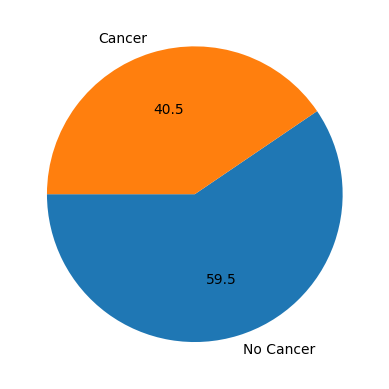

<Figure size 1600x1600 with 0 Axes>

In [7]:
labels_count = cancer_labels.label.value_counts()

plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, autopct='%1.1f')
plt.figure(figsize=(16,16))
plt.show()

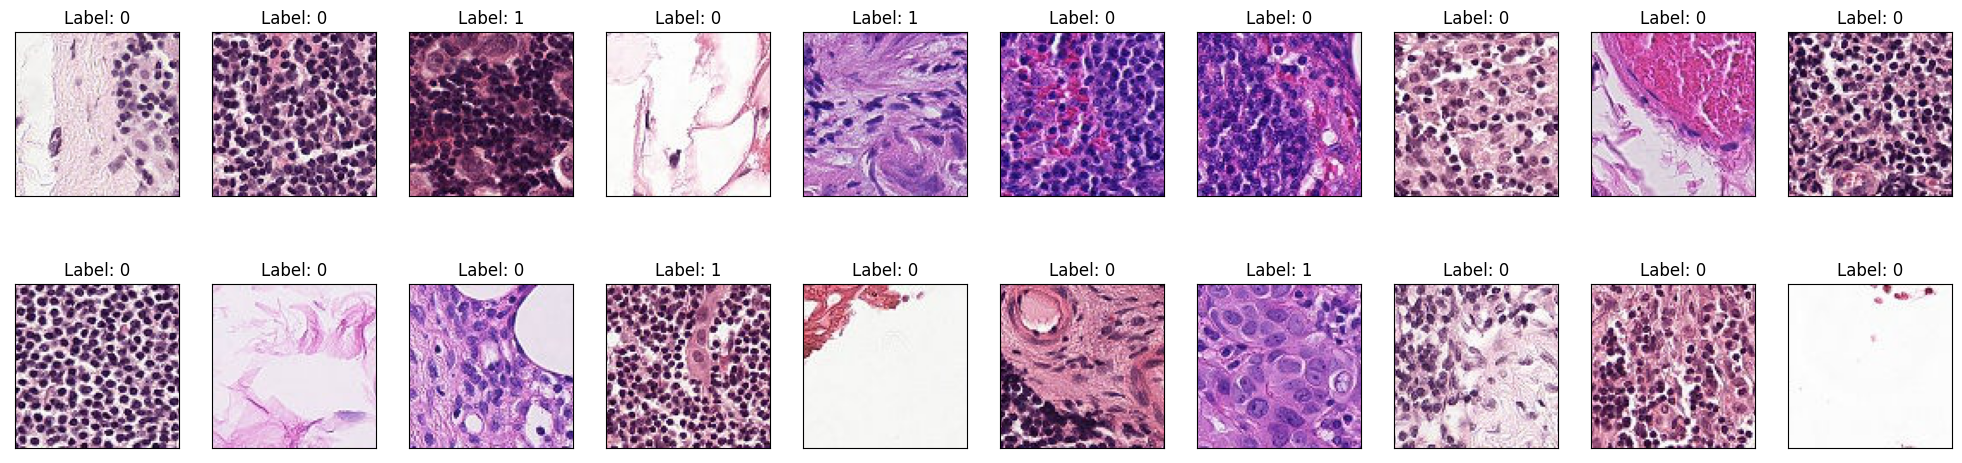

In [8]:
fig = plt.figure(figsize=(25, 6))

train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

<a id='data-preprocessing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Data Preprocessing</div></b>

In [9]:
np.random.seed(0)
train_imgs_orig = os.listdir("/kaggle/input/histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
    selected_image_list.append(img)
len(selected_image_list)

10000

In [10]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:10000]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [11]:
os.mkdir('/kaggle/working/cancer_train_dataset/')
for fname in cancer_train_idx:
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join('/kaggle/working/cancer_train_dataset', fname)
    shutil.copyfile(src, dst)
print('Number of images in downsampled training dataset: ', len(os.listdir("/kaggle/working/cancer_train_dataset")))

Number of images in downsampled training dataset:  7847


In [12]:
os.mkdir('/kaggle/working/cancer_test_dataset/')
for fname in cancer_test_idx:
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join('/kaggle/working/cancer_test_dataset/', fname)
    shutil.copyfile(src, dst)
print('Number of images in downsampled testing dataset: ', len(os.listdir("/kaggle/working/cancer_test_dataset/")))

Number of images in downsampled testing dataset:  1989


In [13]:
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
    label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
    id_list.append(label_tuple['id'].values[0])
    label_list.append(label_tuple['label'].values[0])

In [14]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,f4fdc910da56063188ea442d307178abbbacfdfc,0
1,3eda6ab16d1edebe3ecf608ee2b14d68c68b8666,1
2,17e643a00e78ea98cf55e6e33e3e208de9965868,0
3,5868d1d23be2a49ffb9dc6d2ac97c323808db6de,1
4,fbfe6e61423639e320773483ce52f47c494054fb,0


In [15]:
img_class_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

<a id='data-loading'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Loading the Dataset</div></b>

In [16]:
class LoadCancerDataset(Dataset):
    def __init__(self, datafolder, transform, labels_dict={}):
        self.datafolder = datafolder
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]
        label = self.labels_dict[img_name_short]
        return image, label

In [17]:
class CancerDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_workers, data_dir):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        """
        The prepare_data method was intentionally left empty as we have the dataset in our directory.
        """
        pass

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:            
            train_set_full = LoadCancerDataset(
                datafolder=f'{self.data_dir}/cancer_train_dataset',  
                transform=T.Compose([
                    T.Resize(224),
                    T.RandomHorizontalFlip(),
                    T.RandomVerticalFlip(),
                    T.ToTensor()
                ]),
                labels_dict=img_class_dict
            )
            train_set_size = int(len(train_set_full) * 0.9)
            valid_set_size = len(train_set_full) - train_set_size
            self.train_ds, self.val_ds = random_split(train_set_full, [train_set_size, valid_set_size])  

        # Assign test dataset for use in dataloader(s)     
        if stage == "test" or stage is None:            
            self.test_ds = LoadCancerDataset(
                datafolder=f'{self.data_dir}/cancer_test_dataset',
                transform=T.Compose([
                    T.Resize(224),
                    T.ToTensor()]),
                labels_dict=img_class_dict
            )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader( self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader( self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

<a id='model-building'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Buiding the Model</div></b>

In [18]:
class CancerImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001, num_classes = 2):   
        super().__init__()
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()   
        self.num_classes = num_classes
        self.accuracy = Accuracy(task="binary", num_classes=num_classes)  
        self.f1_score = F1Score(task="binary", num_classes=num_classes)
        self.history = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}
        
        self.pretrain_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False
        
        self.pretrain_model.fc = nn.Sequential(
            nn.Linear(self.pretrain_model.fc.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024,self.num_classes)
        )

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):       
        outputs, targets, loss, preds = self._common_step(batch, batch_idx)     
        train_accuracy = self.accuracy(preds, targets)           
        self.history['train_loss'].append(loss.item())
        self.history['train_acc'].append(train_accuracy.item())      
        self.log_dict(
            {"train_loss": loss,"train_acc": train_accuracy,},
            on_step=False, on_epoch=True, prog_bar=True)  
        return {"loss":loss, 'train_acc': train_accuracy}
            
    def validation_step(self, batch, batch_idx):      
        outputs, targets, loss, preds = self._common_step(batch, batch_idx)  
        val_accuracy = self.accuracy(preds, targets)     
        self.history['val_loss'].append(loss.item())
        self.history['val_acc'].append(val_accuracy.item())     
        self.log_dict(
            {"val_loss": loss,"val_acc": val_accuracy},
            on_step=False, on_epoch=True, prog_bar=True,
        )
        return {"loss":loss, 'val_acc': val_accuracy}
    
    def test_step(self, batch, batch_idx):
        outputs, targets, loss, preds = self._common_step(batch, batch_idx)
        test_accuracy = self.accuracy(preds, targets)           
        f1_score = self.f1_score(preds, targets)         
        self.log_dict(
            {"test_loss": loss,"test_acc": test_accuracy, "test_f1_score": f1_score},
            on_step=False, on_epoch=True, prog_bar=True,
        )
        return {"test_loss":loss, "test_accuracy":test_accuracy, "test_f1_score": f1_score}
    
    def _common_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        loss = self.loss_fn(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        return outputs, targets, loss, preds

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

<a id='creating-callbacks'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Creating Callbacks</div></b>

In [19]:
# Callback to monitor metrics
class PrintCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print("Epoch {}, train loss: {:.3f}, train acc: {:.3f} ".format(trainer.current_epoch, 
                                         trainer.callback_metrics['train_loss'].item(),
                                         trainer.callback_metrics['train_acc'].item()))
        print("-" * 10)

    def on_validation_epoch_end(self, trainer, pl_module):
        print("Epoch {}, val loss: {:.3f}, val acc: {:.3f} ".format(trainer.current_epoch, 
                                      trainer.callback_metrics['val_loss'].item(), 
                                      trainer.callback_metrics['val_acc'].item()))

<a id='model-traing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Training the Model</div></b>

In [20]:
#Setting the hyperparameters
hyper_params = {
    # Training hyperparameters
    "NUM_CLASSES": 2, 
    "LEARNING_RATE": 0.001, 
    "BATCH_SIZE": 128,
    "NUM_EPOCHS": 15,
    # Dataset
    "DATA_DIR": "/kaggle/working",
    "NUM_WORKERS": os.cpu_count(),
    # Compute related
    "ACCELERATOR": "auto",
    "DEVICES": "auto",
    }

In [21]:
# Create an experiment with your API key
comet_logger = CometLogger(
    api_key= my_api_key,
    workspace="tirendaz",
    project_name="cancer-tracking"
)

# Logging hyperparamters
comet_logger.experiment.log_parameters(hyper_params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz/cancer-tracking/ba10f257a75d4290b066711bee22b71b



In [22]:
my_dataloader = CancerDataModule(
        batch_size=hyper_params["BATCH_SIZE"],
        num_workers=hyper_params["NUM_WORKERS"],
        data_dir=hyper_params["DATA_DIR"])

my_model = CancerImageClassifier(
        num_classes=hyper_params["NUM_CLASSES"],
        learning_rate=hyper_params["LEARNING_RATE"])

my_trainer = pl.Trainer(
        logger=comet_logger,
        accelerator=hyper_params["ACCELERATOR"],
        devices=hyper_params["DEVICES"],
        callbacks=[PrintCallback()],  
        max_epochs=hyper_params["NUM_EPOCHS"])

my_trainer.fit(my_model, my_dataloader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.8MB/s]


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0, val loss: 0.679, val acc: 0.691 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, val loss: 0.372, val acc: 0.828 
Epoch 0, train loss: 0.404, train acc: 0.819 
----------


Validation: 0it [00:00, ?it/s]

Epoch 1, val loss: 0.335, val acc: 0.856 
Epoch 1, train loss: 0.339, train acc: 0.858 
----------


Validation: 0it [00:00, ?it/s]

Epoch 2, val loss: 0.324, val acc: 0.865 
Epoch 2, train loss: 0.323, train acc: 0.865 
----------


Validation: 0it [00:00, ?it/s]

Epoch 3, val loss: 0.298, val acc: 0.878 
Epoch 3, train loss: 0.295, train acc: 0.877 
----------


Validation: 0it [00:00, ?it/s]

Epoch 4, val loss: 0.356, val acc: 0.860 
Epoch 4, train loss: 0.288, train acc: 0.881 
----------


Validation: 0it [00:00, ?it/s]

Epoch 5, val loss: 0.318, val acc: 0.860 
Epoch 5, train loss: 0.280, train acc: 0.881 
----------


Validation: 0it [00:00, ?it/s]

Epoch 6, val loss: 0.307, val acc: 0.875 
Epoch 6, train loss: 0.252, train acc: 0.891 
----------


Validation: 0it [00:00, ?it/s]

Epoch 7, val loss: 0.313, val acc: 0.857 
Epoch 7, train loss: 0.261, train acc: 0.894 
----------


Validation: 0it [00:00, ?it/s]

Epoch 8, val loss: 0.322, val acc: 0.870 
Epoch 8, train loss: 0.256, train acc: 0.893 
----------


Validation: 0it [00:00, ?it/s]

Epoch 9, val loss: 0.282, val acc: 0.890 
Epoch 9, train loss: 0.240, train acc: 0.903 
----------


Validation: 0it [00:00, ?it/s]

Epoch 10, val loss: 0.312, val acc: 0.869 
Epoch 10, train loss: 0.230, train acc: 0.905 
----------


Validation: 0it [00:00, ?it/s]

Epoch 11, val loss: 0.304, val acc: 0.879 
Epoch 11, train loss: 0.219, train acc: 0.910 
----------


Validation: 0it [00:00, ?it/s]

Epoch 12, val loss: 0.298, val acc: 0.874 
Epoch 12, train loss: 0.219, train acc: 0.913 
----------


Validation: 0it [00:00, ?it/s]

Epoch 13, val loss: 0.302, val acc: 0.864 
Epoch 13, train loss: 0.210, train acc: 0.916 
----------


Validation: 0it [00:00, ?it/s]

Epoch 14, val loss: 0.310, val acc: 0.878 
Epoch 14, train loss: 0.210, train acc: 0.913 
----------


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tirendaz/cancer-tracking/ba10f257a75d4290b066711bee22b71b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [84]       : (0.15707260370254517, 0.6877921223640442)
COMET INFO:     train_acc [15]  : (0.8190314173698425, 0.9158878326416016)
COMET INFO:     train_loss [15] : (0.21029016375541687, 0.4038691520690918)
COMET INFO:     val_acc [15]    : (0.8280254602432251, 0.89044588804245)
COMET INFO:     val_loss [15]   : (0.2821190059185028, 0.3723088800907135)
COMET INFO:   Parameters:
COMET INFO:     ACCELERATOR   : auto
COMET INFO:     BATCH_SIZE    : 128
COMET INFO:     DATA_DIR      : /kaggle/working
COMET INFO:   

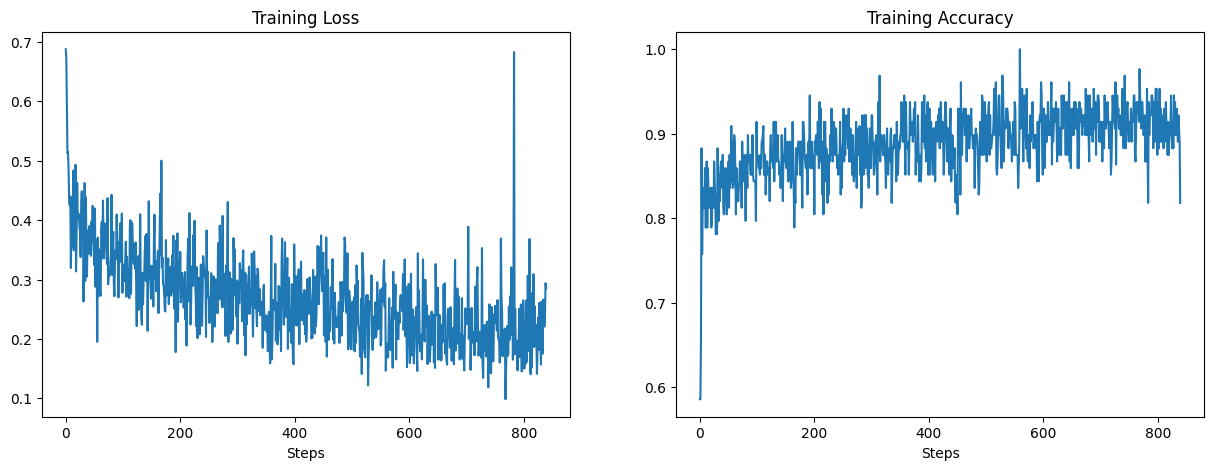

In [23]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.title('Training Loss')
plt.xlabel('Steps')
plt.plot(my_model.history['train_loss'])

plt.subplot(1,2,2)
plt.title('Training Accuracy')
plt.xlabel('Steps')
plt.plot(my_model.history['train_acc'])

<a id='model-evaluation'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Model Evaluation</div></b>

In [24]:
my_dataloader.setup()
my_trainer.test(model=my_model, dataloaders=my_dataloader.test_dataloader())

Testing: 0it [00:00, ?it/s]

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz/cancer-tracking/ba10f257a75d4290b066711bee22b71b



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8788335919380188     │
│       test_f1_score       │    0.8410623073577881     │
│         test_loss         │    0.30680519342422485    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tirendaz/cancer-tracking/ba10f257a75d4290b066711bee22b71b
COMET INFO:   Metrics:
COMET INFO:     test_acc      : 0.8788335919380188
COMET INFO:     test_f1_score : 0.8410623073577881
COMET INFO:     test_loss     : 0.30680519342422485
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET INFO: Uploading 1 metrics, params and output messages


[{'test_loss': 0.30680519342422485,
  'test_acc': 0.8788335919380188,
  'test_f1_score': 0.8410623073577881}]

In [25]:
# Saving Model in Comet-ML
from comet_ml.integration.pytorch import log_model
log_model(comet_logger.experiment, my_model, model_name="my_pl_model")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz/cancer-tracking/ba10f257a75d4290b066711bee22b71b



In [26]:
# Ending our experiment
comet_logger.experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tirendaz/cancer-tracking/ba10f257a75d4290b066711bee22b71b
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     model-element : 2 (97.99 MB)
COMET INFO: 
COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 97.70 MB/97.99 MB


<a id='conclusion'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Conclusion</div></b>

In this notebook, we learned how to perform image classification with PyTorch-Lightning. Thanks for taking the time! If you enjoyed it, please consider upvoting.


🔗 Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎

## Resource
- [Deep Learning with PyTorch Lightning](https://www.amazon.com/dp/180056161X)